## Energy Generation Analysis
- This script analyzes energy generation and fuel stock data published by the U.S Energy Information Administration
- The data used includes energy generation data from across the country
- Also included are stock levels of fuels used, including oil, coal, petcoke, and boiler fuels
- Data Source: https://www.eia.gov/electricity/data/eia923/

### Hypothesis
- Energy generation will be inversely proportional to fuel stock. Therefore, if energy generation in a given period of time increases, the respective stock of fuel will decrease.

### Observations
- The stock of each fuel type showed the same right-tailed distribution when aggregated country wide. Indicating that a small number of power plants maintain a much higher stock of fuel than other in the country. 
- The same ditribution held true for power generation. A small number of plants form an outlier by generating significantly more energy than those in the rest of the country.
- Power generation from all fuel types except petcoke has declined each year from 2008 to 2017
- No fuel stock showed a correlation to generation except boiler fuel

### Conclusions
- Generally, the hypothesis that energy generation was inversely proportional to fuel stock was not supported. 
- With the exception of petcoke, all fuel types showed no relationship between stock and generation.

### I. Import Packages & Data

In [1]:
#Import packages
import os
import numpy as np
import scipy.stats
import pandas as pd
import datetime as dt
import re
import copy
from calendar import month_name

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(rc={'lines.markeredgewidth': 0.1})

In [2]:
#View files in current working directory
path = os.getcwd() + '/' 'Raw_Data'
files = os.listdir(path)

#Create a list of all excel files
files_ = [i for i in files if i[-4:]=='xlsx' or i[-3:]=='xls']

#### Verify the sheets in each file match

In [3]:
#Store list of sheets to load into dataframes for analysis
keep_sheets = ['Page 2 Oil Stocks Data', 'Page 2 Coal Stocks Data', 'Page 2 Petcoke Stocks Data', \
               'Page 3 Boiler Fuel Data', 'Page 4 Generator Data']

In [4]:
#Define function to import data from excel
def import_data(file, sheet_name, skiprows=0):
    return pd.read_excel(file, sheet_name=sheet_name, skiprows=skiprows)

In [5]:
#Populate dictionary with data from all required sheets of each file
data = {}
for sheet in keep_sheets:
    data[sheet] = {}

for sheet, dict_ in data.items():
    for file in files_:
        filepath = path + '/' + file
        end_file_idx = file.rfind('.')
        dict_[file[:end_file_idx]] = import_data(filepath, sheet)

### II. Data Cleaning

#### Remove any remaining blank rows at the top of the dataframes
- There is inconsistent formatting between Excel files/sheets 
- Some additional clean up is needed to remove any additional headers, notes, etc that are not related to the data

In [6]:
def remove_blank_rows(df, n_rows=15):
    '''
    This function checks the first n_rows rows of a dataframe and removes any rows
    with blanks in the first four columns (ID columns)
    
    Input
        df (dataframe): Dataframe to edit
        n_rows (int): Number of rows to check
        
    Output(df): pandas dataframe (w/ empty rows removed)
    '''
    #Create dummy 'drop' column to mark cols to drop
    df['drop'] = False

    #Check the first n_rows rows for blanks in all ID cols (first four) and drop the row if found
    for i in range(n_rows):
        if any(df.iloc[i, :2].isnull()):
            df.loc[i, 'drop'] = True
    df_2 = df.loc[df['drop'] != True, df.columns != 'drop'].copy()
    df_2.reset_index(drop=True, inplace=True)

    #Set new columns
    df_2.columns = df_2.loc[0, ]

    #Drop first row (no longer needed) and reset index
    df_2.drop(0, inplace=True)
    df_2.reset_index(drop=True, inplace=True)

    return df_2

In [7]:
#Apply remove_blank_rows func to all df's stored in data dict
##Create a new copy of the data dict to retain raw data
data_2 = copy.deepcopy(data)

for sheet, d in data_2.items():
    for file, df in d.items():
        data_2[sheet][file] = remove_blank_rows(df)

#### Format col names to match between df's from the same Excel sheet
- Validate that column names match before concatenating dataframes

In [8]:
def format_col_names(col_idx):
    '''
    This function edits each column name in a list of dataframe columns
    to standardize formatting across all dataframes. Will only 
    operate on strings. 
    
    Input(index): Raw column index
    Output(list): Formatted column list
    '''
    col_list = list(col_idx).copy()
    for i in range(len(col_list)):
        if type(col_list[i]) is str:
            #Replace spaces with underscore
            col_list[i] = re.sub(' ', '_', col_list[i])

            #Remove all non-alphanumeric characters
            col_list[i] = re.sub('[\W]+', '', col_list[i])

            #Replace any double underscores with single underscore
            col_list[i] = re.sub('__', '_', col_list[i])

            #Change all characters to lowercase
            col_list[i] = col_list[i].lower()
    
    return col_list

In [9]:
#Format column names of all df's
for sheet, d in data_2.items():
    for file, df in d.items():
        df.columns = format_col_names(df.columns)

#### Identify inconsistencies in  df column names & number of columns

In [10]:
#Identify df's with column counts that don't match the rest
for sheet, d in data_2.items():
    col_cnt = []
    for file, df in d.items():
        col_cnt.append(len(df.columns))
    
    actual_col_cnt = scipy.stats.mode(col_cnt)
    for i in range(len(col_cnt)):
        if col_cnt[i] != actual_col_cnt[0]:
            print((sheet, actual_col_cnt[0], col_cnt[i]))

- All dataframes within each sheet have the same number of columns

#### Standardize column names across all df's within each sheet

In [11]:
#Confirm that all df's within each sheet have the same number of columns
for sheet in keep_sheets:
    num_cols = data_2[sheet]['2008'].shape[1]
    for file in files_:
        end_file_idx = file.rfind('.')
        if num_cols != data_2[sheet][file[:end_file_idx]].shape[1]:
            print(sheet, file, num_cols, data_2[sheet][file[:end_file_idx]].shape[1])

In [12]:
#Set all column names within each sheet to match
##Set columns in each dataframe equal to the columns of the first df (2008 file)
for sheet in keep_sheets:
    col_list = data_2[sheet]['2008'].columns
    for file in files_:
        data_2[sheet][file[:end_file_idx]].columns = col_list

#### Concatenate all dataframes within each Excel sheet

In [13]:
#Create a new dictionary to store the combined datasets
combined_data = {}

for sheet in keep_sheets:
    combined_data[sheet] = pd.concat(data_2[sheet])

In [14]:
def format_index(df):
    '''
    This function resets the index of the provided dataframe, drops one of the previous indices,
    and renames the other.
    
    Input(dataframe): Provided dataframe
    Output(dataframe): New dataframe with formatted index
    '''
    df_2 = df.reset_index()
    df_2.drop('level_1', axis=1, inplace=True)
    df_2.rename({'level_0' : 'report_year'}, axis=1, inplace=True)
    return df_2

In [15]:
#Reformat all df's in the combined_data dict
combined_data_2 = copy.deepcopy(combined_data)

for sheet, df in combined_data_2.items():
    combined_data_2[sheet] = format_index(df)

In [16]:
#Limit Boiler Fuel data to only observations in short ton units
combined_data_2['Page 3 Boiler Fuel Data'] = \
combined_data_2['Page 3 Boiler Fuel Data'].loc[combined_data_2['Page 3 Boiler Fuel Data']['physical_unit_label']=='short tons', ]

#Reset index
combined_data_2['Page 3 Boiler Fuel Data'].reset_index(inplace=True)

### III. Create final dataset

In [17]:
#Start with a copy of the 'Page 4 Generator Data' as the base dataframe
df_gen = combined_data_2['Page 4 Generator Data'].copy()

#### Pivot data to prepare it for joining

In [18]:
#Define general lists of columns that will be used to prepare / join data
id_cols = ['report_year', 'plant_id', 'operator_id']

general_stocks_val_cols = ['quantityjanuary', 'quantityfebruary', 'quantitymarch', 'quantityapril',
       'quantitymay', 'quantityjune', 'quantityjuly', 'quantityaugust',
       'quantityseptember', 'quantityoctober', 'quantitynovember',
       'quantitydecember']

boiler_fuel_val_cols = ['quantity_of_fuel_consumed_january', 'quantity_of_fuel_consumed_february', 
                          'quantity_of_fuel_consumed_march', 'quantity_of_fuel_consumed_april', 
                          'quantity_of_fuel_consumed_may', 'quantity_of_fuel_consumed_june', 
                          'quantity_of_fuel_consumed_july', 'quantity_of_fuel_consumed_august', 
                          'quantity_of_fuel_consumed_september', 'quantity_of_fuel_consumed_october',
                          'quantity_of_fuel_consumed_november', 'quantity_of_fuel_consumed_december']

final_dataset_val_cols = ['net_generation_january', 'net_generation_february', 'net_generation_march', 
                          'net_generation_april', 'net_generation_may', 'net_generation_june', 
                          'net_generation_july', 'net_generation_august', 'net_generation_september', 
                          'net_generation_october', 'net_generation_november', 'net_generation_december']

In [19]:
#Define func to pivot data and prepare for join with generation data
def pivot_data(df, vals, idx):
    '''
    This function pivots a dataframe based on value and index columns provided.
    After pivot, the columns are re-ordered to match the vals list and the
    index is reset.
    
    Input:
        df (dataframe): Dataframe to pivot
        vals (list): List of columns to aggregate
        idx (list): List of columns to use a keys in the pivot table

    Output (dataframe): Pivoted / formatted dataframe
    '''
    df_new = df.pivot_table(values=vals, index=idx, aggfunc=np.sum).copy()
    return df_new.reset_index()

In [20]:
#Pivot all dataframes that will be joined with the energy generation data
df_oil_stock = pivot_data(combined_data_2['Page 2 Oil Stocks Data'], general_stocks_val_cols, id_cols)
df_coal_stock = pivot_data(combined_data_2['Page 2 Coal Stocks Data'], general_stocks_val_cols, id_cols)
df_petcoke_stock = pivot_data(combined_data_2['Page 2 Petcoke Stocks Data'], \
                              general_stocks_val_cols, id_cols)
df_boiler_fuel = pivot_data(combined_data_2['Page 3 Boiler Fuel Data'], boiler_fuel_val_cols, id_cols)

In [21]:
#Pivot final data set
df_gen_2 = pivot_data(df_gen, final_dataset_val_cols, id_cols)

In [22]:
#Define func to finish preparing dataframes for join
def prep_data(df, fuel_type, data_col_name='stock'):
    '''
    This function will finish preparing data for join by creating month
    and data type columns. Columns will also be renamed/reordered. Creating 
    the month column will utilize the pre-defined 'find_month' function.
    
    Input:
        df (dataframe): Input dataframe to be formatted
        fuel_type (str): Value to populate fuel_type col
        data_col_name (str): Name for new data column. Default value set to 'monthly_avg'
    Output:
        df_new (dataframe): Formatted dataframe
    '''
    #Extract month from level_3 feature, create data_type and fuel_type features
    df['month'] = df['level_3'].apply(find_month)
    df['fuel_type'] = fuel_type
    
    #Drop cols no longer needed
    df_2 = df.drop('level_3', axis=1)
    
    #Move monthly_avg col to end of col list and rename
    col_list = list(df_2.columns)
    col_list.remove(0)
    col_list.append(0)
    df_3 = df_2[col_list].copy()
    df_3.rename({0 : data_col_name}, axis=1, inplace=True)
    
    #Move month col
    col_list = list(df_3.columns)
    old_idx = col_list.index('month')
    col_list.insert(1, col_list.pop(old_idx))
    df_4 = df_3[col_list].copy()
    
    return df_4

In [23]:
def find_month(x):
    '''Use regex expression to extract month name from column values'''
    pattern = '|'.join(month_name[1:])
    return re.search(pattern, x, re.IGNORECASE).group(0)

In [24]:
#Prepare supplemental datasets for join with generation data
df_oil_stock_2 = prep_data(df_oil_stock, 'oil')
df_coal_stock_2 = prep_data(df_coal_stock, 'coal')
df_petcoke_stock_2 = prep_data(df_petcoke_stock, 'petcoke')
df_boiler_fuel_2 = prep_data(df_boiler_fuel, 'boiler fuel')

In [25]:
#Prepare generation data for join
df_gen_3 = prep_data(df_gen_2, 'energy', 'generation')

#### Concat stock/fuel df's prior to join with generation data

In [26]:
df_stock_fuel = pd.concat([df_oil_stock_2, df_coal_stock_2, df_petcoke_stock_2, df_boiler_fuel_2], axis=0)

#### Join the generation data with the stock / fuel data

In [27]:
#Define function to join data
def join_data(left_df, right_df, id_cols):
    '''
    This function performs a left join between two dataframes using
    an input for the id cols.
    
    Input:
        left_df (dataframe): Main dataframe to join data to
        right_df (dataframe): Supplemental dataframe
        id_cols (list): List of col names contained in both df's
                        to perform join on
    
    Output (dataframe): New dataframe resulting from the join
    '''
    return left_df.merge(right_df, how='left', on=id_cols)

In [28]:
#Define new id_cols list to include new cols created by data pivot
id_cols_2 = ['report_year', 'month', 'plant_id', 'operator_id']

In [29]:
#Add oil stock data to generation dataset
df_final = join_data(df_gen_3, df_stock_fuel, id_cols_2)

#### Clean up final data set to prepare for visualization

In [30]:
#Drop cols that are no longer needed
df_final_2 = df_final.drop('fuel_type_x', axis=1)

#Rename columns as needed
df_final_3 = df_final_2.rename({'fuel_type_y' : 'fuel_type'}, axis=1)

In [31]:
#Convert object dtypes to numeric where needed
for col in ['generation', 'stock']:
    df_final_3[col] = pd.to_numeric(df_final_3[col], errors='coerce')

### IV. Vizualize Data

In [32]:
df_final_3.head()

,report_year,month,plant_id,operator_id,generation,fuel_type,stock
0,2008,january,3,195,936513.0,boiler fuel,340778.0
1,2008,february,3,195,554264.0,boiler fuel,167669.0
2,2008,march,3,195,599258.0,boiler fuel,205825.0
3,2008,april,3,195,689965.0,boiler fuel,245074.0
4,2008,may,3,195,1009282.0,boiler fuel,417942.0


#### Summary Statistics
- Caclulate a range of summary statistics to get a high level view of the data

In [33]:
df_final_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282715 entries, 0 to 282714
Data columns (total 7 columns):
report_year    282715 non-null object
month          282715 non-null object
plant_id       282715 non-null int64
operator_id    282715 non-null object
generation     270369 non-null float64
fuel_type      233973 non-null object
stock          190049 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 17.3+ MB


In [34]:
def summary_stats(df):
    '''This function will display summary statistics on the input dataframe'''
    print(df.info())
    print('\n')
    print(df.describe())

In [35]:
summary_stats(df_final_3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282715 entries, 0 to 282714
Data columns (total 7 columns):
report_year    282715 non-null object
month          282715 non-null object
plant_id       282715 non-null int64
operator_id    282715 non-null object
generation     270369 non-null float64
fuel_type      233973 non-null object
stock          190049 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 17.3+ MB
None


            plant_id    generation         stock
count  282715.000000  2.703690e+05  1.900490e+05
mean    21262.171374  1.810663e+05  1.497804e+05
std     23524.447676  3.020227e+05  2.931564e+05
min         3.000000 -1.410140e+05  0.000000e+00
25%      2408.000000  8.566000e+03  5.317000e+03
50%      7210.000000  4.051900e+04  3.379100e+04
75%     50807.000000  2.192340e+05  1.550580e+05
max     61838.000000  2.267069e+06  4.327758e+06


#### Distribution Plots
- Create violin plots of generation and stock by fuel type to determine the shape of the data distributions

In [36]:
def plot_dist(df, feature, title, xlabel, sliced_by=None):
    '''
    This function will generate a violin plot of the provided 
    dataframe feature distribution.
    
    Input:
        df (dataframe): Dataframe containing feature to display
        feature (str): Name of feature within df to plot
        title (str): Title of chart
        xlabel (str): x-axis label
        sliced_by (str or None): If value provided, slice the feature by the provided value
    
    Output: None
    '''
    if sliced_by:
        fig = sns.violinplot(df.loc[df['fuel_type']==sliced_by, feature])
    else:
        fig = sns.violinplot(df[feature])
    
    fig.set_title(title)
    fig.set_xlabel(xlabel)

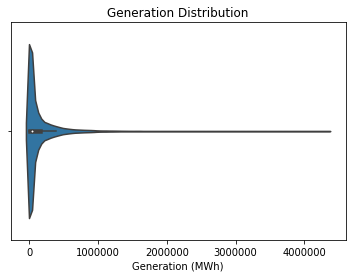

In [37]:
#Plot the distribution of the 'monthly_generation' feature
dist_features_gen = {'df' : df_final_3, 'feature' : 'stock',
                'title' : 'Generation Distribution', 'xlabel' : 'Generation (MWh)'}

plot_dist(**dist_features_gen)

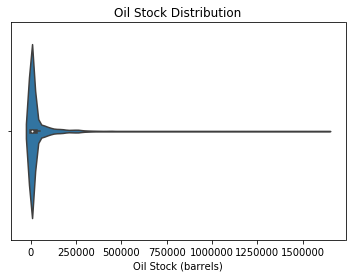

In [38]:
#Plot the distribution of the oil stocks
dist_features_oil = {'df' : df_final_3, 'feature' : 'stock',
                'title' : 'Oil Stock Distribution', 'xlabel' : 'Oil Stock (barrels)',
                'sliced_by' : 'oil'}

plot_dist(**dist_features_oil)

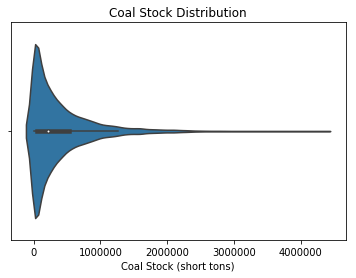

In [39]:
#Plot the distribution of the coal stocks
dist_features_coal = {'df' : df_final_3, 'feature' : 'stock',
                'title' : 'Coal Stock Distribution', 'xlabel' : 'Coal Stock (short tons)',
                'sliced_by' : 'coal'}

plot_dist(**dist_features_coal)

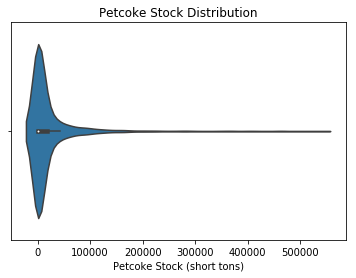

In [40]:
#Plot the distribution of the petcoke stocks
dist_features_petcoke = {'df' : df_final_3, 'feature' : 'stock',
                'title' : 'Petcoke Stock Distribution', 'xlabel' : 'Petcoke Stock (short tons)',
                'sliced_by' : 'petcoke'}

plot_dist(**dist_features_petcoke)

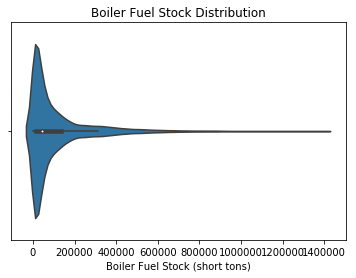

In [41]:
#Plot the distribution of the boiler fuel stocks
dist_features_boiler = {'df' : df_final_3, 'feature' : 'stock',
                'title' : 'Boiler Fuel Stock Distribution', 'xlabel' : 'Boiler Fuel Stock (short tons)',
                'sliced_by' : 'boiler fuel'}

plot_dist(**dist_features_boiler)

#### Time Series Plots
- Plot plot generation and stock metrics against report year to look for any time series trends

In [42]:
#Aggregate the data by year
df_agg = df_final_3.pivot_table(values=['generation', 'stock'],
                                index=['report_year', 'fuel_type'], aggfunc=np.sum)
df_agg.reset_index(inplace=True)

In [43]:
def plot_time_series(df, feature, title, xlabel='Report Year', ylabel=None):
    '''
    This function generates a time series plot of the input feature.
    
    Input:
        df (dataframe): Dataframe containing features to plot
        feature (str): String value representing the feature within the dataframe to plot
        title (str): Title of chart
        xlabel (str): x-axis label of the chart
        ylabel (str): y-axis label of the chart
    
    Output: None
    '''
    #Create lineplot object
    time_series = sns.lineplot('report_year', feature, hue='fuel_type', data=df)
    #Set title and x-axis and y-axis labels
    time_series.set_title(title)
    time_series.set_xlabel(xlabel)
    time_series.set_ylabel(ylabel)
    #Format legend, move to outside the figure area
    handles, labels = time_series.get_legend_handles_labels()
    time_series.legend(handles=handles[1:], labels=labels[1:], title='Fuel Type', bbox_to_anchor=(1, 1))

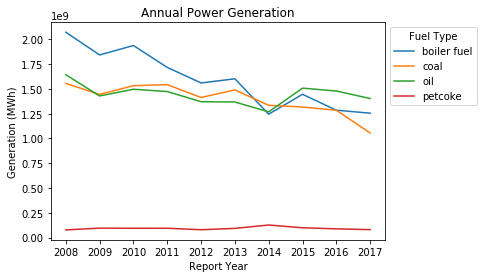

In [44]:
#Create time series plot of power generation by fuel type
ts_feat_gen = {'df' : df_agg, 'feature' : 'generation', 'title' : 'Annual Power Generation', 
               'ylabel' : 'Generation (MWh)'}

plot_time_series(**ts_feat_gen)

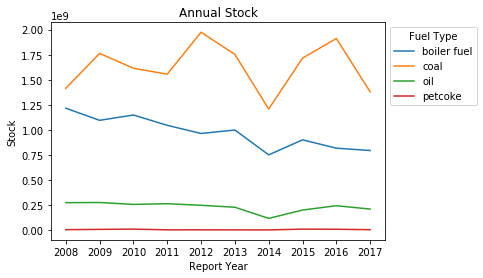

In [45]:
#Create time series plot of fuel stock by fuel type
ts_feat_stock = {'df' : df_agg, 'feature' : 'stock', 'title' : 'Annual Stock', 
               'ylabel' : 'Stock'}

plot_time_series(**ts_feat_stock)

#### Generation vs. Stock by Fuel Type
- Plot variables against each other to look for any correlations

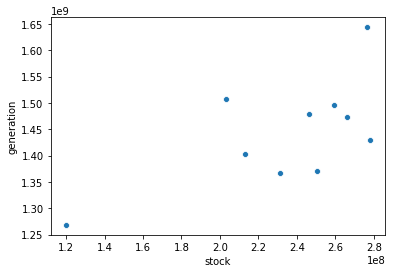

In [46]:
df_slice = df_agg.loc[df_agg['fuel_type']=='oil', ]

sns.scatterplot('stock', 'generation', data=df_slice)
plt.show()

In [47]:
def corr_plot(df, fuel_type, x_feat='stock', y_feat='generation', 
              title='Feature Correlation', xlabel=None, ylabel=None):
    '''
    This function generates a scatter plot of x_feat vs. y_feat from the 
    provided dataframe sliced by the fuel type provided.
    
    Input:
        df (dataframe): Dataframe containing x_feat and y_feat
        fuel_type (str): Value to slice df by
        x_feat (str): Name of the feature in df to plot on the x-axis
        y_feat (str): Name of the feature in df to plot on the y-axis
        title (str): String to set as chart title
        xlabel (str): x-axis label
        ylabel (str): y-axis label
        
    Output: None
    '''
    #Create slice of df
    df_slice = df.loc[df['fuel_type']==fuel_type, ]
    #Create chart object and format
    corr_scatter = sns.scatterplot(x_feat, y_feat, data=df_slice)
    corr_scatter.set_title(title)
    corr_scatter.set_xlabel(xlabel)
    corr_scatter.set_ylabel(ylabel)

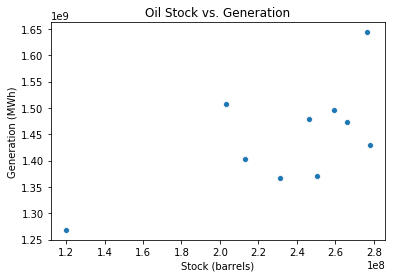

In [48]:
#Generate scatter plot for oil stock vs generation
corr_feat_oil = {'df' : df_agg, 'fuel_type' : 'oil', 'x_feat' : 'stock', 'y_feat' : 'generation',
             'title' : 'Oil Stock vs. Generation', 'xlabel' : 'Stock (barrels)', 
             'ylabel' : 'Generation (MWh)'}
corr_plot(**corr_feat_oil)

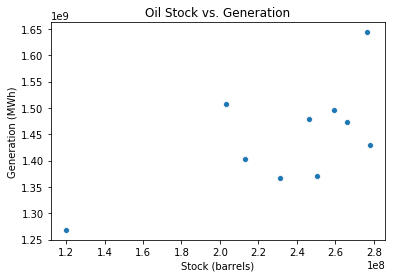

In [49]:
#Generate scatter plot for coal stock vs generation
corr_feat_coal = {'df' : df_agg, 'fuel_type' : 'coal', 'x_feat' : 'stock', 'y_feat' : 'generation',
             'title' : 'Coal Stock vs. Generation', 'xlabel' : 'Stock (short tons)', 
             'ylabel' : 'Generation (MWh)'}
corr_plot(**corr_feat_oil)

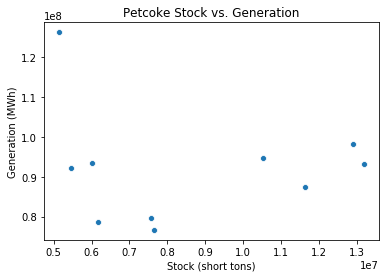

In [50]:
#Generate scatter plot for petcoke stock vs generation
corr_feat_petcoke = {'df' : df_agg, 'fuel_type' : 'petcoke', 'x_feat' : 'stock', 'y_feat' : 'generation',
             'title' : 'Petcoke Stock vs. Generation', 'xlabel' : 'Stock (short tons)', 
             'ylabel' : 'Generation (MWh)'}
corr_plot(**corr_feat_petcoke)

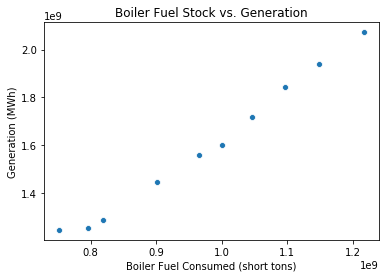

In [51]:
#Generate scatter plot for boiler fuel consumed vs generation
corr_feat_boiler = {'df' : df_agg, 'fuel_type' : 'boiler fuel', 'x_feat' : 'stock', 'y_feat' : 'generation',
             'title' : 'Boiler Fuel Stock vs. Generation', 'xlabel' : 'Boiler Fuel Consumed (short tons)', 
             'ylabel' : 'Generation (MWh)'}
corr_plot(**corr_feat_boiler)